In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import torchvision.transforms as T
import numpy as np

fcn = models.segmentation.fcn_resnet101(
    pretrained=True
).eval()  ## We load a segmentation model from pytorch

c:\Users\androgo\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\androgo\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [1]:

from google.colab import drive

drive.mount("/content/drive", force_remount=True)
%cd '/content/drive/My Drive/Colab Notebooks/Labs/Computer Vision/Segmentation'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Labs/Computer Vision/Segmentation


In [ ]:
# model = load_model('/content/drive/MyDrive/AML_Lab_Assignment/GANS/cgan_generator.h5')

In [ ]:
import os

os.getcwd()

'c:\\Users\\androgo\\Documents\\Python Scripts\\myLabProject\\Computer Vision'

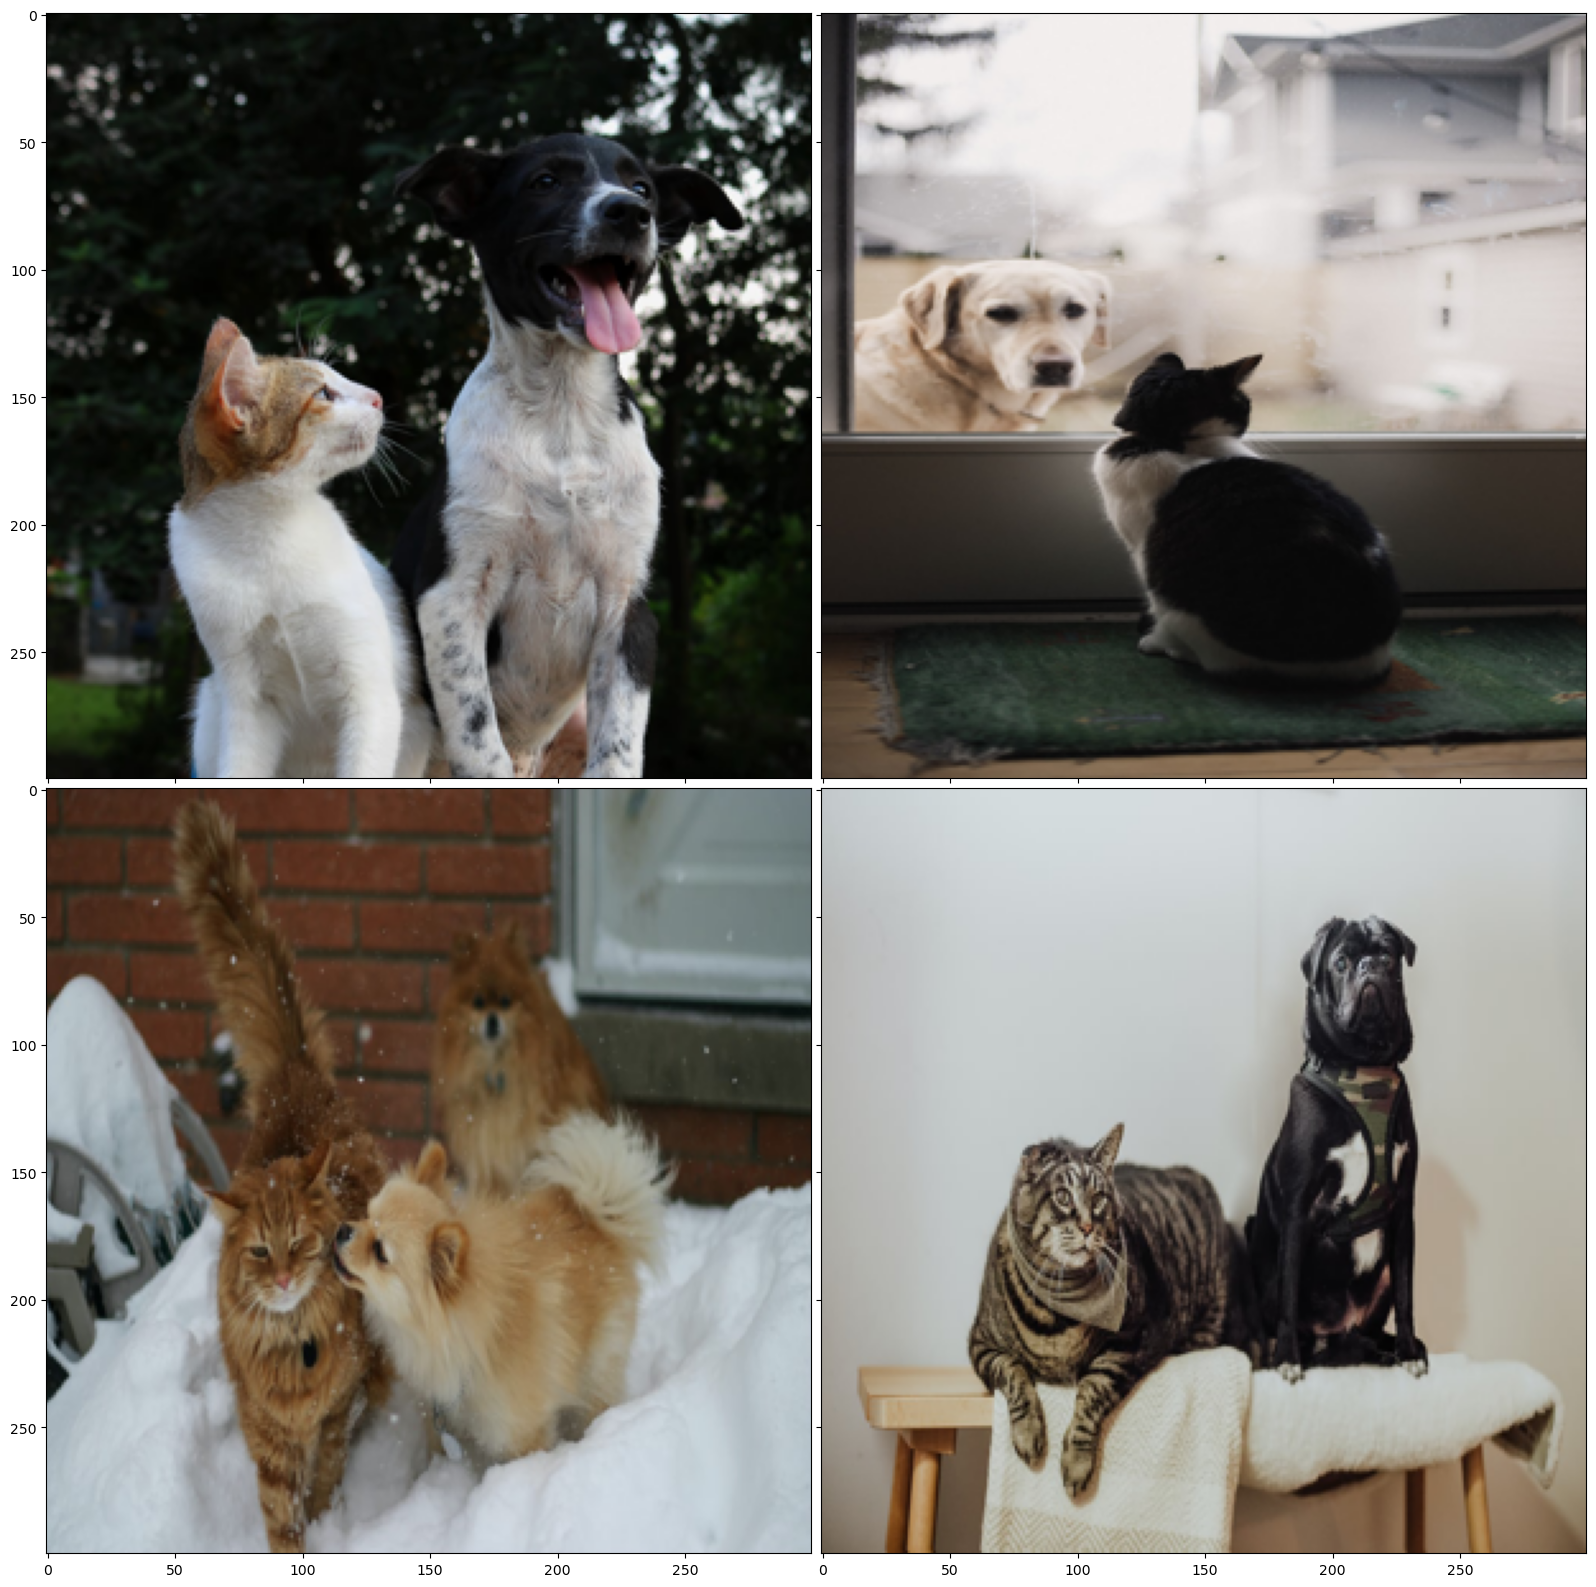

In [ ]:
def img_reshape(img):
    img = Image.open("./Images/" + img).convert("RGB")
    img = img.resize((300, 300))
    img = np.asarray(img)
    return img


images = os.listdir("./Images")
img_arr = []

for image in images:
    img_arr.append(img_reshape(image))


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(20.0, 20.0))
grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(2, 2),  # creates 2x2 grid of axes
    axes_pad=0.1,  # pad between axes
)

for ax, im in zip(grid, img_arr):
    ax.imshow(im)

plt.show()

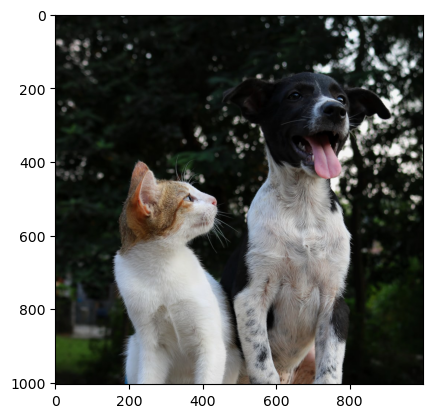

In [ ]:
# Open and show the img
img = Image.open(r"Images/cat_dog_1.jpg")

plt.imshow(img)
plt.show()

In [ ]:
transform = transforms.Compose([transforms.PILToTensor()])

# transform = transforms.PILToTensor()
# Convert the PIL image to Torch tensor
img_tensor = transform(img)

transforms.functional.get_image_size(img_tensor)

[1000, 1005]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


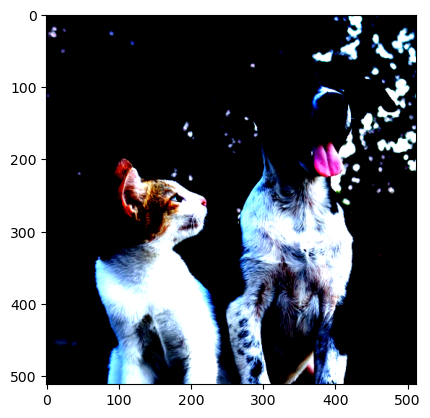

torch.Size([1, 3, 512, 512])


In [ ]:
# Apply the needed transformations

transforms = T.Compose(
    [
        T.Resize(556),
        T.CenterCrop(512),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)  # Imagenet specific
inp = transforms(img).unsqueeze(0)
plt.imshow(inp.squeeze().permute(1, 2, 0))
plt.show()
print(inp.shape)

In [ ]:
# Pass the input through the net and get the segmentation output (same size tensor but with the 21 labels instead of channels)
out = fcn(inp)["out"]
print(out.shape)  # [batch_size, label_size, w, h]

torch.Size([1, 21, 512, 512])


In [ ]:
# With squeeze we get rid of the 1 dimension. Argmax applied on dim=0 (after squeeze) allows us to keep max_index per pixel position
labeled_img = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print(labeled_img.shape)
print(np.unique(labeled_img))

(512, 512)
[ 0  8 12]


In [ ]:
# Helper function to decode the image with labels
def decode_segmap(image, nc=21):

    ## The model is trained on the COCO dataset, and can predict these 21 classes. Try changing colors if you want!
    label_colors = np.array(
        [
            (0, 0, 0),  # 0=background
            # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
            (128, 0, 0),
            (0, 128, 0),
            (128, 128, 0),
            (0, 0, 128),
            (128, 0, 128),
            # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
            (0, 128, 128),
            (128, 128, 128),
            (64, 0, 0),
            (192, 0, 0),
            (64, 128, 0),
            # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
            (192, 128, 0),
            (64, 0, 128),
            (192, 0, 128),
            (64, 128, 128),
            (192, 128, 128),
            # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
            (0, 64, 0),
            (128, 64, 0),
            (0, 192, 0),
            (128, 192, 0),
            (0, 64, 128),
        ]
    )

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = (
            image == l
        )  # Create a boolean array (same size) with true where image indx is same as l

        # fill when True
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    # Create a 3d array with rgb (w, h, channels)
    rgb = np.stack([r, g, b], axis=2)
    return rgb

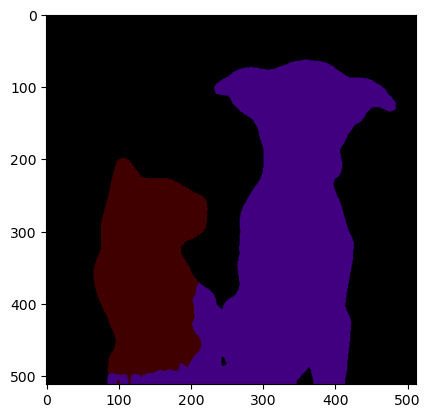

In [ ]:
rgb = decode_segmap(labeled_img)
plt.imshow(rgb)
plt.show()

In [ ]:
## Putting it all together!


def segment(net, path):
    img = Image.open(path)
    # Show original img
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    trf = T.Compose(
        [
            T.Resize(256),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    inp = trf(img).unsqueeze(0)
    out = net(inp)["out"]
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    print(np.unique(om))
    rgb = decode_segmap(om)

    # Show labeled img
    plt.imshow(rgb)
    plt.axis("off")
    plt.show()

    labeled = Image.fromarray(rgb).convert("RGBA")  # To blend we need the Alpha channel
    src_img = img
    src_img = src_img.resize(labeled.size)
    alphaBlended1 = Image.blend(src_img.convert("RGBA"), labeled, alpha=0.5)

    plt.imshow(alphaBlended1)
    plt.axis("off")
    plt.show()

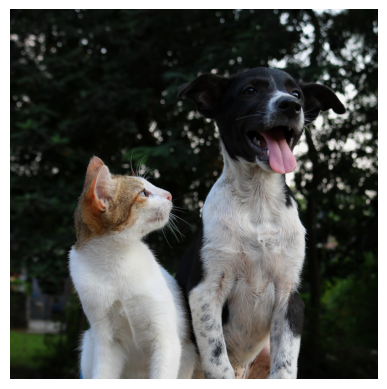

[ 0  8 12]


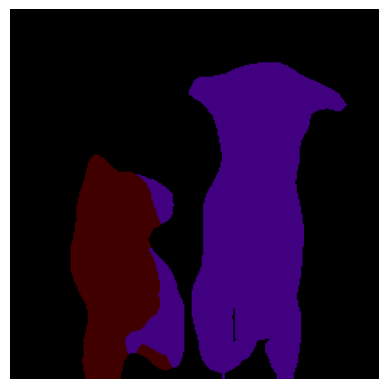

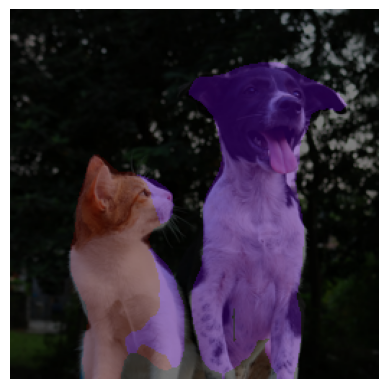

In [ ]:
segment(fcn, "Images/cat_dog_1.jpg")